# Essentials Notebook
This notebook provides most important and must have tools for early stage analysis.
It allows to quickly verify reward function and identify potential problems.

Analysis is divided into 2 sections:
- Vehicle Behaviour
- Reward Properties

There are few code explanations, because it is assumed, that you have already visited *Training_analysis* notebook and have some knowledge about parameters described here. Non standard implementations are documented.

## Import modules

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from deepracer.tracks import TrackIO, Track
from deepracer.logs import CloudWatchLogs as cw, \
    SimulationLogsIO as slio, \
    AnalysisUtils as au, \
    PlottingUtils as pu

## Load track

In [2]:
!ls tracks/

AmericasGeneratedInclStart.npy	New_York_Eval_Track.npy
AWS_track.npy			New_York_Track.npy
Bowtie_track.npy		Oval_track.npy
Canada_Eval.npy			reInvent2019_track.npy
Canada_Training.npy		reInvent2019_wide_mirrored.npy
China_eval_track.npy		reInvent2019_wide.npy
China_track.npy			reinvent_base.npy
H_track.npy			Spain_track.npy
LGSWide.npy			Straight_track.npy
London_Loop_Train.npy		Tokyo_Training_track.npy
Mexico_track_eval.npy		Vegas_track.npy
Mexico_track.npy		Virtual_May19_Train_track.npy


In [3]:
tu = TrackIO()

In [4]:
track = tu.load_track("Spain_track")

Loaded 259 waypoints


## Load log

In [5]:
stream_name = 'adv-alpha' ## CHANGE This to your simulation application ID
fname = 'logs/deepracer-%s.log' %stream_name  # The log will be downloaded into the specified path

In [6]:
cw.download_log(fname, stream_prefix=stream_name)  # add force=True if you downloaded the file before but want to repeat

Log file exists, use force=True to download again


In [7]:
EPISODES_PER_ITERATION = 30 #  Set to value of your hyperparameter in training

data = slio.load_data(fname)
df = slio.convert_to_pandas(data, episodes_per_iteration=EPISODES_PER_ITERATION)

df = df.sort_values(['episode', 'steps'])

In [8]:
df

iteration  episode  steps       x       y       yaw  steer  throttle  \
0              1        0      3  0.1256 -2.1742 -179.6575   30.0       1.5   
1              1        0      4  0.1103 -2.1745 -179.6075  -30.0       1.5   
2              1        0      5 -0.0181 -2.1805 -178.3491   20.0       1.6   
3              1        0      6 -0.1001 -2.1856 -177.4096  -20.0       1.6   
4              1        0      7 -0.2051 -2.1942 -176.3283   30.0       1.5   
...          ...      ...    ...     ...     ...       ...    ...       ...   
51321         34     1019     91 -6.3130 -1.7402  155.2675  -10.0       1.6   
51322         34     1019     92 -6.4485 -1.6714  153.7511  -30.0       1.5   
51323         34     1019     93 -6.5159 -1.6321  152.1236   30.0       1.5   
51324         34     1019     94 -6.5827 -1.5889  149.9965  -20.0       1.6   
51325         34     1019     95 -6.6718 -1.5261  147.0965  -20.0       1.6   

       action  reward  done on_track  progress  closest_waypoint  track_len  \
0         6.0  1.0634     0     True    0.3703                 1       60.0   
1         0.0  1.0330     0     True    0.3957                 1       60.0   
2         5.0  2.5938     0     True    0.6098                 1       60.0   
3         1.0  1.1826     0     True    0.7465                 1       60.0   
4         6.0  1.2395     0     True    0.9215                 2       60.0   
...       ...     ...   ...      ...       ...               ...        ...   
51321     2.0  0.0128     0    False   15.8866                26       60.0   
51322     0.0  0.0139     0    False   16.0939                27       60.0   
51323     6.0  0.0118     0    False   16.1629                27       60.0   
51324     1.0  0.0109     0    False   16.1659                27       60.0   
51325     1.0  0.0129     1    False   16.3115                27       60.0   

                timestamp  
0      1591007372.8769803  
1      1591007372.9804797  
2      1591007373.1103237  
3      1591007373.2090511  
4      1591007373.3098142  
...                   ...  
51321  1591016766.8200078  
51322  1591016766.9380758  
51323  1591016767.0223436  
51324  1591016767.1356962  
51325  1591016767.2803476  

[51326 rows x 16 columns]

# Vehicle Behaviour
## Action distribution
More even the distribution is the better the action space is matched with the track. Also can detect not used actions.

In [9]:
df['action'].value_counts().sort_index()

0.0    12545
1.0     4614
2.0     6644
3.0     7770
4.0     6905
5.0     4582
6.0     8266
Name: action, dtype: int64

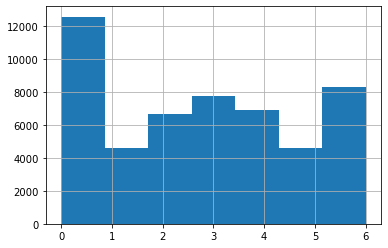

In [10]:
df['action'].hist(bins=int(df['action'].max() + 1))

-30.0    12545
 30.0     8266
 0.0      7770
 10.0     6905
-10.0     6644
-20.0     4614
 20.0     4582
Name: steer, dtype: int64

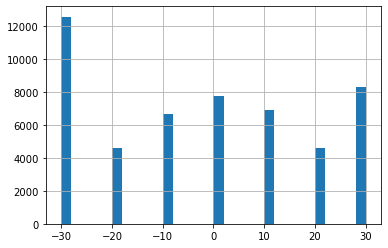

In [11]:
df['steer'].hist(bins=30)
df['steer'].value_counts()

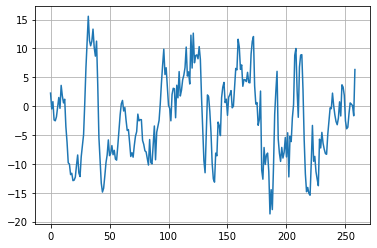

In [50]:
mean_steer = df[['steer', 'closest_waypoint']].groupby(by='closest_waypoint').mean()
#plt.figure(figsize=(16,6))
plt.plot(mean_steer)
plt.grid()

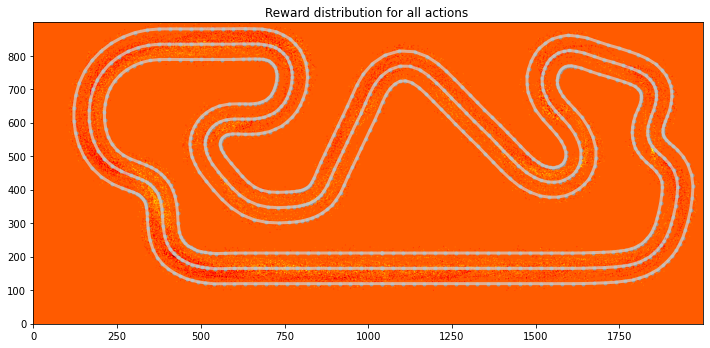

<Figure size 432x288 with 0 Axes>

In [48]:
# once cmap support for pu.plot_track is added, plot steering around the track
pu.plot_track(df, track, value_field='steer', margin=1)#, cmap='bwr')

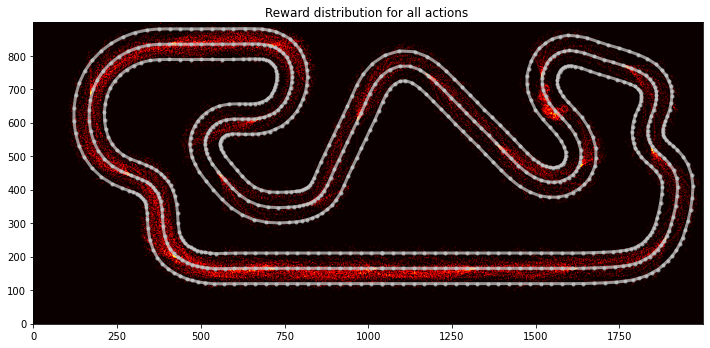

<Figure size 432x288 with 0 Axes>

In [14]:
pu.plot_track(df, track, value_field='throttle', margin=1)

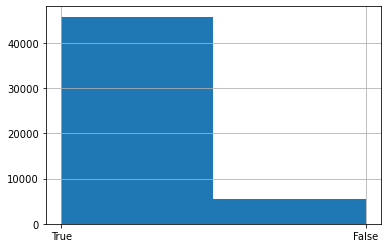

In [12]:
df['on_track'].hist(bins=2)

## Progress per steps
The higher the value the better.

In [15]:
pps = df['progress'].values / (1 + df['steps'].values)
df['pps'] = np.where(pps < 0.0, 0.0, pps)

In [16]:
sample = df[df['pps'] < 0.5]

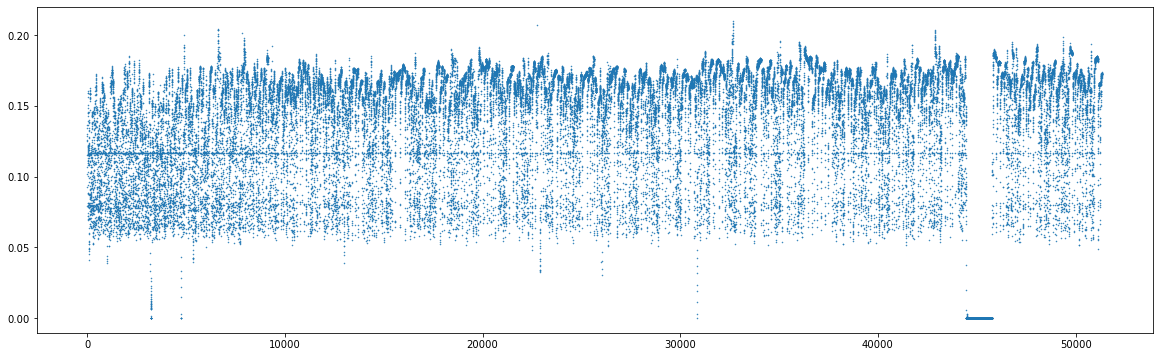

In [17]:
plt.figure(figsize=(20,6))
plt.plot(np.arange(0,len(sample)), sample['pps'], '.', markersize=1)

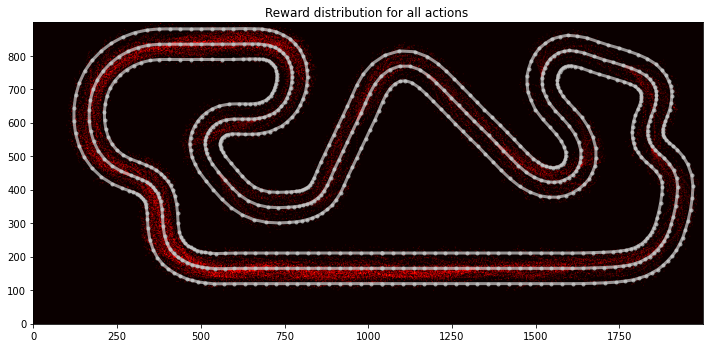

<Figure size 432x288 with 0 Axes>

In [18]:
pu.plot_track(sample, track, value_field='pps', margin=1)

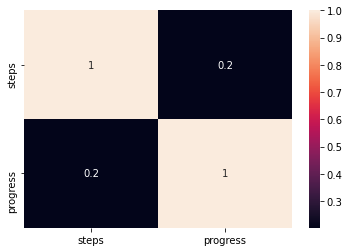

In [19]:
sns.heatmap(df[['steps', 'progress']].corr(), annot=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe8554cef70>,
      dtype=object)

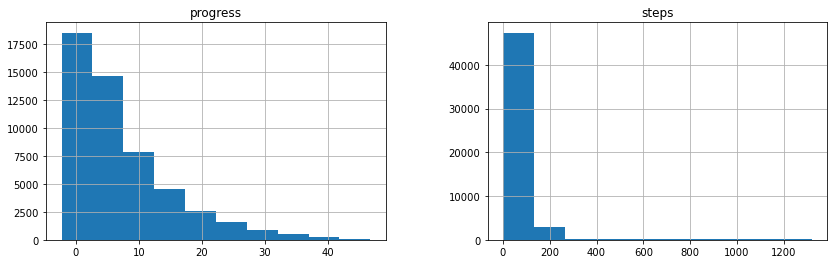

In [20]:
df[['steps', 'progress']].hist(figsize=(14,4))

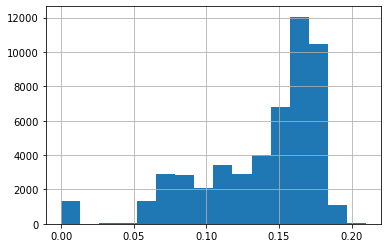

In [21]:
df['pps'].hist(bins=16)

## Progress and progression tempo
Tempo is the track distance covered in a single step.

> **NOTE** that it is calculated from progress so zig-zag does not count. We care about distance covered towards the finish line.

The higher the value the better progress car is making.

In [22]:
def tempo(progress):
    result = np.zeros(len(progress))
    last = 0.0
    for x in range(0,len(progress)):
        d = 0.0
        p = progress[x] / 100.0
        if last < p:
            d = p - last
        result[x] = d
        last = max(float(p), 0.0)
    return result

In [23]:
# Logarithmic progress for increased contrast (subject to change if a better method of contrast increase is developed)
df['log_progress'] = [math.log(1.0 + max(r['progress'],0.0) / 10.0) for _,r in df.iterrows()]

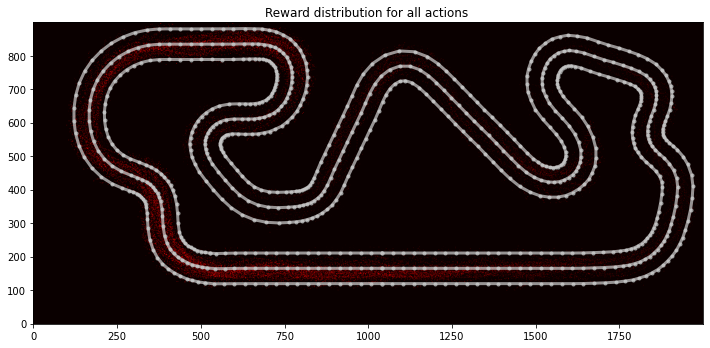

<Figure size 432x288 with 0 Axes>

In [24]:
pu.plot_track(df, track, value_field='log_progress', margin=1)

In [25]:
df['tempo'] = tempo(df['progress']) * df['track_len'][0]

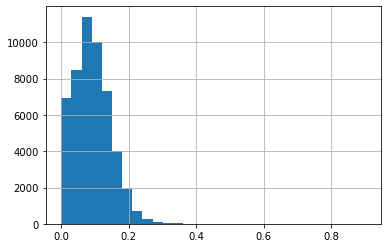

In [26]:
df['tempo'].hist(bins=30)

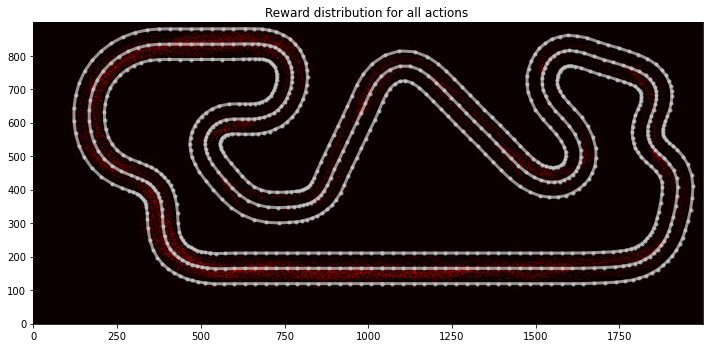

<Figure size 432x288 with 0 Axes>

In [27]:
pu.plot_track(df[df['tempo'] < 0.25], track, value_field='tempo')

# Training Metrics
Plot metrics with a console like plot.

In [28]:
metrics = df[['iteration','episode','reward','tempo']].groupby(by=['iteration','episode']).sum()
iter_metrics = metrics[['reward','tempo']].groupby(by='iteration').mean()

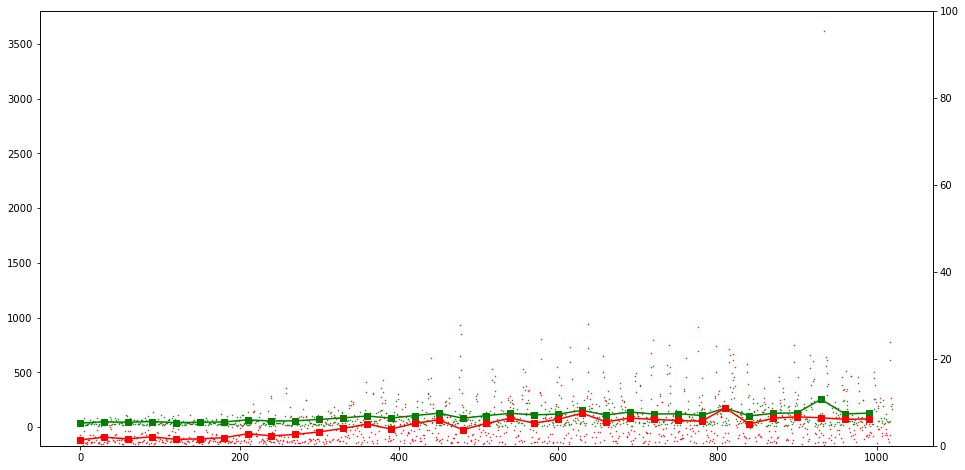

In [29]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot()
axp = ax.twinx()
axp.set_ylim((0,100))

epi = np.arange(len(metrics))
ax.plot(epi, metrics['reward'].values, 'g.', markersize=1)
axp.plot(epi, metrics['tempo'].values, 'r.', markersize=1)

it = np.arange(epi.min(), epi.max(), EPISODES_PER_ITERATION)
ax.plot(it, iter_metrics['reward'].values, 'g-s')
axp.plot(it, iter_metrics['tempo'].values, 'r-s')

# Reward Properties
Analyze returned reward, apply different rewards for comparison.

## Helper definitions

In [30]:
def plot_track(t, fig=None):
    ratio = (lambda x,y: x / y)(*t.size())
    if fig is None:
        fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot()
    ax.axis('equal')
    ax.plot(*t.center_line.T, 'b')
    ax.plot(*t.outer_border.T, 'b')
    ax.plot(*t.inner_border.T, 'b')
    return ax

In [31]:
def df2params(frame, track: Track, mapping=None):
    if mapping is None:
        mapping = {'on_track':'all_wheels_on_track', 'throttle':'speed',
                   'yaw':'heading', 'steer':'steering_angle', 'track_len':'track_length', 'progress':'progress', 'steps':'steps',
                  'x':'x', 'y':'y', 'distance_from_center':'distance_from_center'}
    d = {'closest_waypoints': [frame['closest_waypoint'], (frame['closest_waypoint']+1)%len(track.center_line)]}
    width = np.linalg.norm(track.inner_border[0] - track.outer_border[0])
    d.update({'is_reversed':False, 'waypoints':track.center_line, 'track_width':width})
    d.update({mapping[k]:frame[k] for k in mapping})
    return d

In [32]:
import importlib

### Estimate missing parameters

In [33]:
def dist_from_center(row, waypoints):
    "Adds missing distance_from_center column"
    close = row['closest_waypoint']
    estimated = np.array(waypoints[close])
    pos = np.array([row['x'], row['y']])
    dist = np.linalg.norm(pos - estimated)
    return dist

In [34]:
df['distance_from_center'] = [dist_from_center(r, track.center_line) for _,r in df.iterrows()]

## Apply different reward

In [35]:
name = 'center'
reward = importlib.import_module('rewards.{0}'.format(name))
# Reload module so it is always up to date
importlib.reload(reward)
reward_function = reward.reward_function

In [36]:
original = 'reward'
# Recalculate log can be unncessary because we use original value from memory
if 'log_'+original not in df.columns:
    df['log_' + original] = [math.log(1 + r[original]) for _,r in df.iterrows()]

In [37]:
df[name] = [reward_function(df2params(r, track)) for _,r in df.iterrows()]
df['log_' + name] = [math.log(1 + r[name]) for _,r in df.iterrows()]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe853774e80>,
      dtype=object)

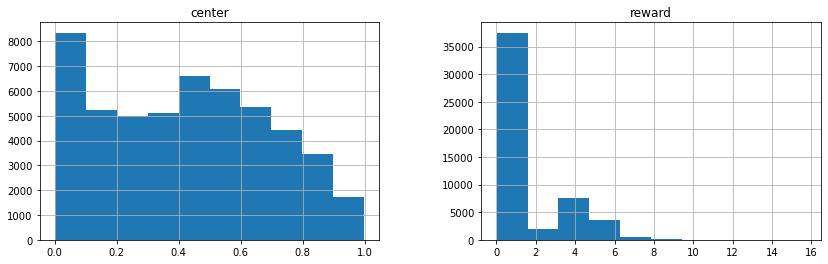

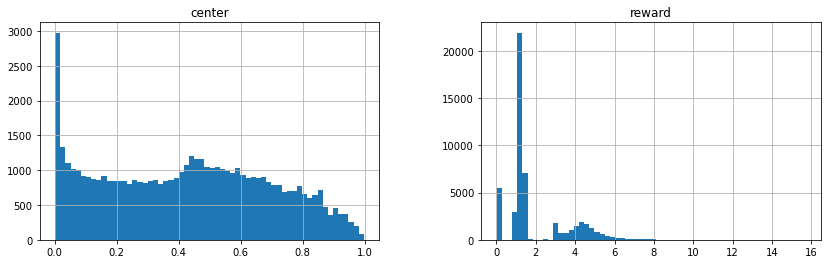

In [38]:
df[[original, name]].hist(figsize=(14,4))
df[[original, name]].hist(figsize=(14,4), bins=60)

In [39]:
df[[original, name]].describe()

reward        center
count  51326.000000  51326.000000
mean       1.948398      0.423871
std        1.642585      0.270178
min        0.009900      0.001000
25%        1.131900      0.185519
50%        1.261000      0.432091
75%        2.987000      0.637732
max       15.694100      0.997170

Text(0.5, 1.0, 'center')

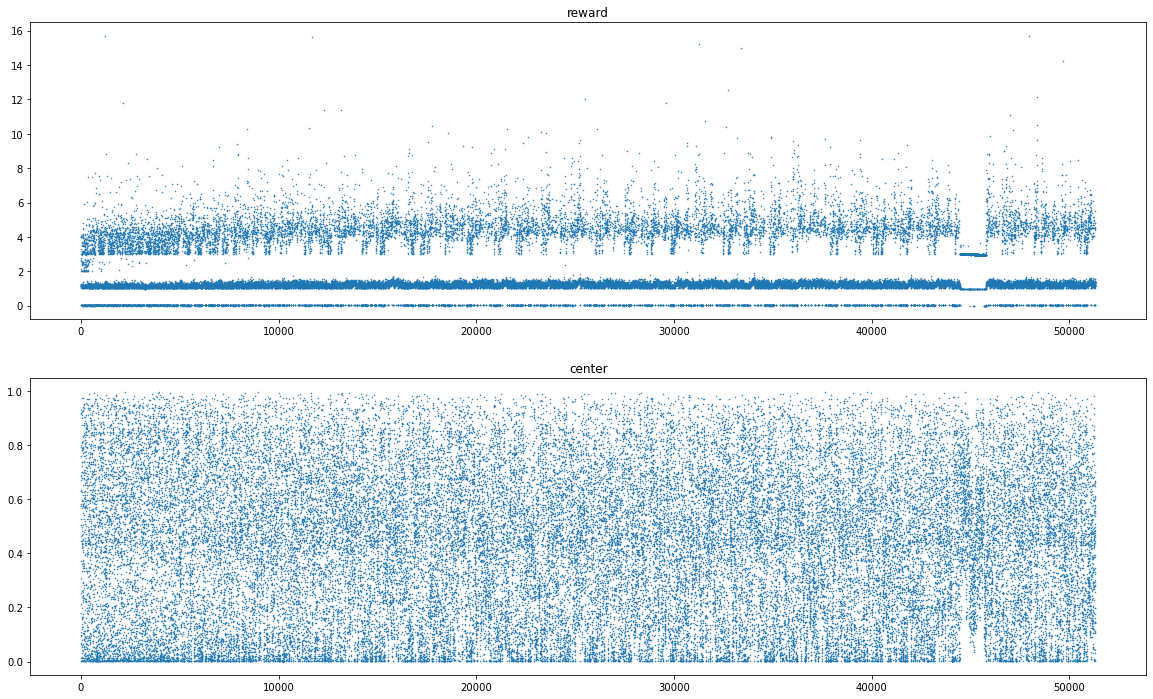

In [40]:
plt.figure(figsize=(20,12))

plt.subplot(2,1,1)
plt.plot(df.index, df[original], '.', markersize=1)
plt.title(original)

plt.subplot(2,1,2)
plt.plot(df.index, df[name], '.', markersize=1)
plt.title(name)

In [41]:
sample = df.sample(frac=0.75)

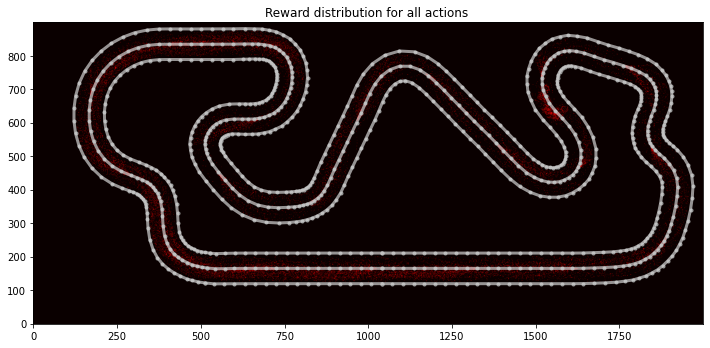

<Figure size 432x288 with 0 Axes>

In [42]:
pu.plot_track(sample, track, value_field='log_{0}'.format(original))

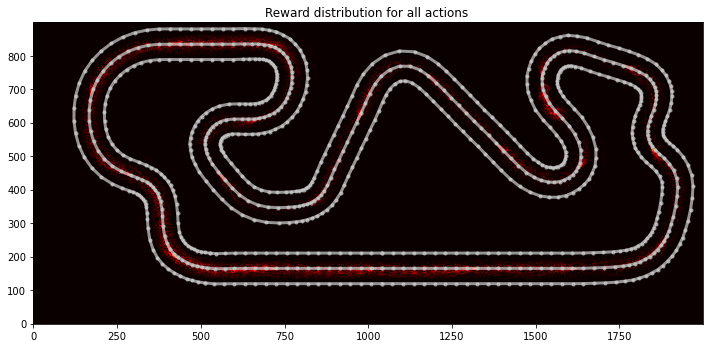

<Figure size 432x288 with 0 Axes>

In [43]:
pu.plot_track(sample, track, value_field='log_{0}'.format(name))

# Bonus : Visualize reward

## Compare functions
Choose your warrior wisely. Your function needs improvement? Incorrect distribution? Don't worry! Let's see which function does suit your needs best!

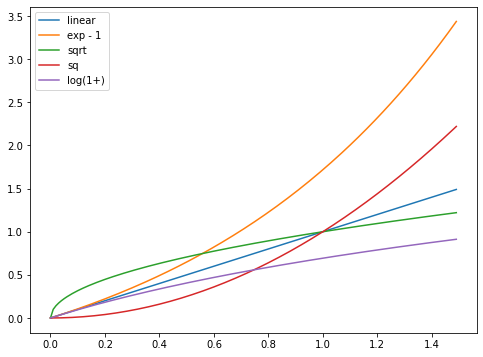

In [65]:
ox = np.arange(0,1.5,0.01)
plt.figure(figsize=(8,6))
plt.plot(ox, ox)
plt.plot(ox, np.exp(ox) - 1)
plt.plot(ox, np.sqrt(ox))
plt.plot(ox, np.power(ox, 2.0))
plt.plot(ox, np.log(1 + ox))
plt.legend(['linear','exp - 1','sqrt','sq','log(1+)'])

## Plot 3d reward distribution

To create a 3d plot we use a sample from our logs and update 2 of its parameters creating a 2d space of inputs. Once that is done we simply iterate over these plane calculating the reward for such parameters combination.

> Z coordinate is the reward result. `jupyter notebook` classical notebook is needed to create interactive plots.

In [ ]:
# Works only with jupyter notebook
%matplotlib notebook

In [44]:
def plot3d_reward(fig, x, y, rewardf):
    "Plot rewardf(x,y) reward to visualize reward resoponse on x,y parameters change"
    X,Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    # ideally array should be passed into the reward, but some rewards use functions from math library, which is incompatible with numpy arrays
    # to solve this problem we calculate reward iteratively
    for r in range(0,Z.shape[0]):
        for c in range(0,Z.shape[1]):
            Z[r,c] = rewardf(X[r,c], Y[r,c])
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X,Y,Z)
    return ax

In [45]:
def updated_params(params, **kwargs):
    p = dict(params)
    p.update(kwargs)
    return p

In [50]:
src = df.sample(n=1)
src

iteration  episode  steps       x       y      yaw  steer  throttle  \
8644          9      262      1 -5.7338 -1.8657  152.891   10.0       1.5   

      action  reward  ...  closest_waypoint track_len           timestamp  \
8644     4.0  1.0012  ...                24      60.0  1590784661.9030929   

          pps  log_progress tempo  distance_from_center  log_reward   heading  \
8644  0.11605      0.022945   0.0              0.023187    0.693747  2.593105   

      log_heading  
8644     1.279017  

[1 rows x 23 columns]

In [51]:
params = df2params(src.iloc[0], track)
rew = lambda x, y: reward_function(updated_params(params, distance_from_center=x, heading=y))

In [52]:
X = np.arange(0.0, params['track_width'], 0.01)
Y = np.arange(-180, 180, 0.1)

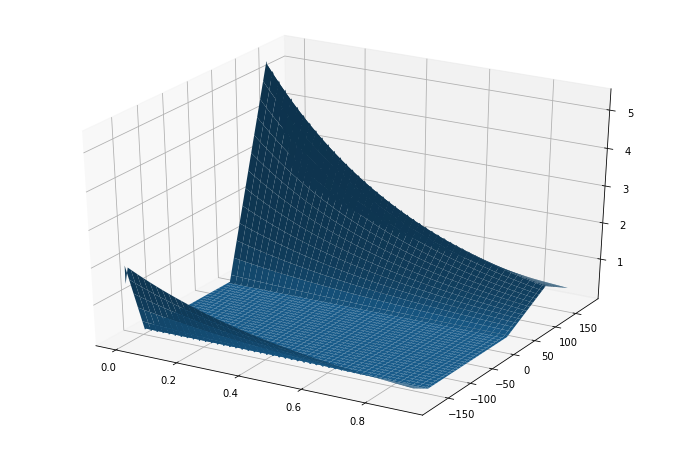

In [53]:
fig = plt.figure(figsize=(12,8))
plot3d_reward(fig, X, Y, rew)

## Plot saved sectors
If your last computed reward function implements sectors global variable storing model records, you can plot it here.

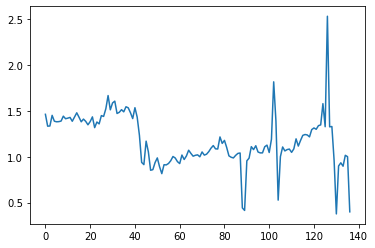

In [390]:
sectors = pd.DataFrame([(a[0],a[1],b) for a,b in reward.sectors.items()], columns=['x', 'y', 'var'])
plt.plot(sectors.index, sectors['var'])

In [64]:
rew(0.0, 120)

5.248811062097708

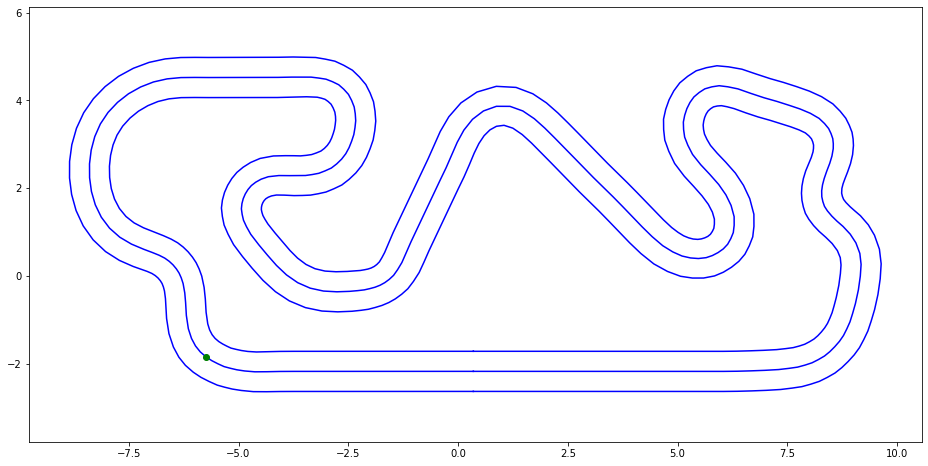

In [119]:
ax = plot_track(track)
ax.plot(*track.center_line[24], 'go')